In [42]:
%pip install -q langchain_community langchain_openai langchain_mongodb langchain_huggingface pymongo openai langchain
%pip install -q opencv-python moviepy faiss-cpu tiktoken torch torchvision 
%pip install --upgrade --quiet langchain--openai langchainhub openai ffmpeg ultralytics

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.2.16 requires langchain-core<0.3.0,>=0.2.38, but you have langchain-core 0.3.9 which is incompatible.
langchain-community 0.2.12 requires langchain-core<0.3.0,>=0.2.30, but you have langchain-core 0.3.9 which is incompatible.
langchain-huggingface 0.0.3 requires langchain-core<0.3,>=0.1.52, but you have langchain-core 0.3.9 which is incompatible.
langchain-mongodb 0.1.8 requires langchain-core<0.3.0,>=0.2.21, but you have langchain-core 0.3.9 which is incompatible.
langchain-text-splitters 0.2.4 requires langchain-core<0.3.0,>=0.2.38, but you have langchain-core 0.3.9 which is incompatible.


In [44]:
import torch
import numpy as np
import cv2
import requests
import json
import torch.nn as nn
from openai import OpenAI
import os
import base64
import time
from moviepy.editor import VideoFileClip
from IPython.display import display, Image
from ultralytics import YOLO
from langchain.prompts import MessagesPlaceholder
from langchain.prompts import ChatPromptTemplate
from collections import Counter
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage
from langchain.embeddings import HuggingFaceEmbeddings
from pymongo.errors import ConnectionFailure
from pymongo import MongoClient
import concurrent.futures
import asyncio
import aiohttp
from langchain.vectorstores import MongoDBAtlasVectorSearch
from langchain.chat_models import ChatOpenAI
from langchain.retrievers import MergerRetriever

In [24]:
model = "gpt-4o-mini-2024-07-18"

os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
client = OpenAI(api_key=OPENAI_API_KEY)


db_client = MongoClient(MONGODB_URI)
db = db_client['dbsparta']
collection = db['dog']

## Ehco Model 베이스

#### STEP.1 Yolo Model 동영상 입력 ➡ 프레임 추출 ➡ 프레임 처리 ➡ 모델 추론 ➡ 결과 출력 (label : breed / bbox / keypoint)

In [27]:
# 비디오
source = "E:/1006/test/2.mp4"

# YOLO 모델 로드 및 실행
yolo_model = YOLO("E:/1006/model/yolo_model.pt")
conf_thresh = 0.7

# LSTM 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load('E:/1006/model/lstm_model.pt', map_location=device)
print("체크포인트 키:", checkpoint.keys())

체크포인트 키: odict_keys(['keypoint_lstm.weight_ih_l0', 'keypoint_lstm.weight_hh_l0', 'keypoint_lstm.bias_ih_l0', 'keypoint_lstm.bias_hh_l0', 'keypoint_lstm.weight_ih_l1', 'keypoint_lstm.weight_hh_l1', 'keypoint_lstm.bias_ih_l1', 'keypoint_lstm.bias_hh_l1', 'skeleton_lstm.weight_ih_l0', 'skeleton_lstm.weight_hh_l0', 'skeleton_lstm.bias_ih_l0', 'skeleton_lstm.bias_hh_l0', 'skeleton_lstm.weight_ih_l1', 'skeleton_lstm.weight_hh_l1', 'skeleton_lstm.bias_ih_l1', 'skeleton_lstm.bias_hh_l1', 'fc.weight', 'fc.bias'])


In [10]:
# YOLO 키포인트를 LSTM 형식으로 변환
def convert_yolo_to_lstm(yolo_keypoints):
    image_width, image_height = 640, 384
    yolo_to_lstm_mapping = {
        16: 0, 23: 4, 8: 5, 2: 6, 7: 7, 1: 8, 10: 9, 4: 10, 9: 11, 3: 12, 12: 13, 13: 14
    }
    lstm_keypoints = np.zeros((15, 2), dtype=float)
    
    for yolo_index, lstm_index in yolo_to_lstm_mapping.items():
        if yolo_index < yolo_keypoints.shape[0]:
            x, y = yolo_keypoints[yolo_index]
            lstm_keypoints[lstm_index] = [x / image_width, y / image_height]
    
    # 이마, 입꼬리, 아래 입술 중앙 처리 (가능한 경우에만)
    if 20 < yolo_keypoints.shape[0]:
        lstm_keypoints[1] = yolo_keypoints[20] / np.array([image_width, image_height])
    if 17 < yolo_keypoints.shape[0]:
        lstm_keypoints[2] = lstm_keypoints[3] = yolo_keypoints[17] / np.array([image_width, image_height])
    
    return lstm_keypoints

# 스켈레톤 데이터 생성
def create_skeleton(keypoints):
    DOG_SKELETON = [
        [0, 1], [0, 2], [2, 3], [1, 4], [4, 5], [4, 6], [5, 7], [6, 8],
        [9, 11], [10, 12], [4, 13], [13, 14], [9, 13], [10, 13], [5, 9],
        [6, 10], [5, 6], [9, 10]
    ]
    skeleton = []
    for start, end in DOG_SKELETON:
        start_point, end_point = keypoints[start], keypoints[end]
        skeleton.extend([start_point[0], start_point[1], end_point[0], end_point[1]])
    return skeleton

# YOLO 결과 처리 및 LSTM 입력 준비
lstm_keypoint_sequence = []
skeleton_sequence = []
breed_counter = Counter()

results = yolo_model.predict(source=source, save=True, conf=conf_thresh, stream=True)
for r in results:
    if r.keypoints is not None and len(r.keypoints) > 0:
        yolo_keypoints = r.keypoints[0].cpu().numpy()
        lstm_keypoints = convert_yolo_to_lstm(yolo_keypoints)
        lstm_keypoint_sequence.append(lstm_keypoints)
        skeleton = create_skeleton(lstm_keypoints)
        skeleton_sequence.append(skeleton)
        
        # YOLO 결과에서 품종 정보 추출 및 카운트
        boxes = r.boxes
        for box in boxes:
            cls = int(box.cls[0])
            class_name = r.names[cls]
            breed_counter[class_name] += 1  # 품종 등장 횟수 증가

lstm_keypoint_sequence = np.array(lstm_keypoint_sequence)
skeleton_sequence = np.array(skeleton_sequence)

print(f"LSTM 키포인트 시퀀스 형태: {lstm_keypoint_sequence.shape}")
print(f"스켈레톤 시퀀스 형태: {skeleton_sequence.shape}")

# 가장 많이 탐지된 품종 선택
if breed_counter:
    most_common_breed = breed_counter.most_common(1)[0][0]
    total_detections = sum(breed_counter.values())
    breed_percentage = (breed_counter[most_common_breed] / total_detections) * 100
    yolo_text = f"가장 많이 탐지된 품종: {most_common_breed} (전체 탐지 중 {breed_percentage:.2f}%)"
else:
    yolo_text = "탐지된 품종 없음"

print("YOLO 분석 결과:")
print(yolo_text)


video 1/1 (frame 1/135) E:\1006\test\2.mp4: 640x384 (no detections), 323.0ms
video 1/1 (frame 2/135) E:\1006\test\2.mp4: 640x384 (no detections), 289.0ms
video 1/1 (frame 3/135) E:\1006\test\2.mp4: 640x384 1 Maltese_dog, 221.0ms
video 1/1 (frame 4/135) E:\1006\test\2.mp4: 640x384 1 Maltese_dog, 201.0ms
video 1/1 (frame 5/135) E:\1006\test\2.mp4: 640x384 1 Maltese_dog, 206.0ms
video 1/1 (frame 6/135) E:\1006\test\2.mp4: 640x384 1 Maltese_dog, 206.0ms
video 1/1 (frame 7/135) E:\1006\test\2.mp4: 640x384 (no detections), 206.0ms
video 1/1 (frame 8/135) E:\1006\test\2.mp4: 640x384 1 Tzu, 219.0ms
video 1/1 (frame 9/135) E:\1006\test\2.mp4: 640x384 (no detections), 204.0ms
video 1/1 (frame 10/135) E:\1006\test\2.mp4: 640x384 (no detections), 201.0ms
video 1/1 (frame 11/135) E:\1006\test\2.mp4: 640x384 (no detections), 298.0ms
video 1/1 (frame 12/135) E:\1006\test\2.mp4: 640x384 (no detections), 209.0ms
video 1/1 (frame 13/135) E:\1006\test\2.mp4: 640x384 (no detections), 213.0ms
video 1/1 (f

#### STEP.2 Yolo Output Data 변환 (yolo v8m, size:640x384)

In [15]:
import torch
import torch.nn as nn
import numpy as np
from ultralytics import YOLO

# YOLO 키포인트를 LSTM 형식으로 변환
def convert_yolo_to_lstm(yolo_keypoints):
    image_width, image_height = 640, 384
    yolo_to_lstm_mapping = {
        16: 0, 23: 4, 8: 5, 2: 6, 7: 7, 1: 8, 10: 9, 4: 10, 9: 11, 3: 12, 12: 13, 13: 14
    }
    lstm_keypoints = np.zeros((15, 2), dtype=float)
    
    for yolo_index, lstm_index in yolo_to_lstm_mapping.items():
        if yolo_index < yolo_keypoints.shape[0]:
            x, y = yolo_keypoints[yolo_index]
            if x == 0 and y == 0:  # YOLO에서 감지되지 않으면 0,0 처리
                lstm_keypoints[lstm_index] = [0, 0]
            else:
                lstm_keypoints[lstm_index] = [x / image_width, y / image_height]

    # 이마, 입꼬리, 아래 입술 중앙 처리 (가능한 경우에만)
    if yolo_keypoints.shape[0] > 20:
        lstm_keypoints[1] = yolo_keypoints[20] / np.array([image_width, image_height])
    if yolo_keypoints.shape[0] > 17:
        lstm_keypoints[2] = lstm_keypoints[3] = yolo_keypoints[17] / np.array([image_width, image_height])

    return lstm_keypoints

# 스켈레톤 데이터 생성
def create_skeleton(keypoints):
    DOG_SKELETON = [
        [0, 1], [0, 2], [2, 3], [1, 4], [4, 5], [4, 6], [5, 7], [6, 8],
        [9, 11], [10, 12], [4, 13], [13, 14], [9, 13], [10, 13], [5, 9],
        [6, 10], [5, 6], [9, 10]
    ]
    skeleton = []
    for start, end in DOG_SKELETON:
        start_point, end_point = keypoints[start], keypoints[end]
        skeleton.extend([start_point[0], start_point[1], end_point[0], end_point[1]])
    return skeleton

# YOLO 결과 처리 및 LSTM 입력 준비
lstm_keypoint_sequence = []
skeleton_sequence = []

results = yolo_model.predict(source=source, save=True, conf=conf_thresh, stream=True)
for r in results:
    if r.keypoints is not None and len(r.keypoints) > 0:
        yolo_keypoints = r.keypoints[0].cpu().numpy()
        lstm_keypoints = convert_yolo_to_lstm(yolo_keypoints)
        lstm_keypoint_sequence.append(lstm_keypoints)
        skeleton = create_skeleton(lstm_keypoints)
        skeleton_sequence.append(skeleton)

lstm_keypoint_sequence = np.array(lstm_keypoint_sequence)
skeleton_sequence = np.array(skeleton_sequence)

print(f"LSTM 키포인트 시퀀스 형태: {lstm_keypoint_sequence.shape}")
print(f"스켈레톤 시퀀스 형태: {skeleton_sequence.shape}")

# LSTM 모델 정의
class ImprovedLSTMModel(nn.Module):
    def __init__(self, keypoint_size, skeleton_size, hidden_size, num_layers, num_classes):
        super(ImprovedLSTMModel, self).__init__()
        self.keypoint_lstm = nn.LSTM(keypoint_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
        self.skeleton_lstm = nn.LSTM(skeleton_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, keypoints, skeleton):
        _, (h_n_keypoints, _) = self.keypoint_lstm(keypoints)
        _, (h_n_skeleton, _) = self.skeleton_lstm(skeleton)
        combined = torch.cat((h_n_keypoints[-1], h_n_skeleton[-1]), dim=1)
        out = self.dropout(combined)
        out = self.fc(out)
        return out
# 모델 파라미터 및 메타데이터 설정
keypoint_size = checkpoint.get('keypoint_size', 30)
skeleton_size = checkpoint.get('skeleton_size', 72)
hidden_size = checkpoint.get('hidden_size', 128)
num_layers = checkpoint.get('num_layers', 2)
num_classes = checkpoint.get('num_classes', checkpoint['fc.weight'].size(0))
all_class_names = checkpoint.get('classes', [f'Class_{i}' for i in range(num_classes)])
metadata = checkpoint.get('metadata', {})

# all_meta 정의 (예시)
all_meta = [
    {"pain": "N/A", "disease": "N/A", "emotion": "N/A", "abnormal_action": "N/A"} for _ in range(num_classes)
]

print(f"키포인트 크기: {keypoint_size}")
print(f"스켈레톤 크기: {skeleton_size}")
print(f"은닉층 크기: {hidden_size}")
print(f"레이어 수: {num_layers}")
print(f"클래스 수: {num_classes}")
print(f"클래스 이름: {all_class_names}")

# 모델 인스턴스 생성
model = ImprovedLSTMModel(keypoint_size, skeleton_size, hidden_size, num_layers, num_classes).to(device)

# 가중치 직접 로드
try:
    model.load_state_dict(checkpoint['model_state_dict'])
except KeyError:
    print("'model_state_dict' 키를 찾을 수 없습니다. 체크포인트에서 직접 가중치를 로드합니다.")
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in checkpoint.items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

model.eval()

# 시퀀스 길이 표준화 (패딩 적용)
target_length = 100
if len(lstm_keypoint_sequence) > target_length:
    lstm_keypoint_sequence = lstm_keypoint_sequence[:target_length]
    skeleton_sequence = skeleton_sequence[:target_length]
elif len(lstm_keypoint_sequence) < target_length:
    padding = [np.zeros_like(lstm_keypoint_sequence[-1])] * (target_length - len(lstm_keypoint_sequence))
    lstm_keypoint_sequence = np.concatenate([lstm_keypoint_sequence, padding], axis=0)
    skeleton_padding = [np.zeros_like(skeleton_sequence[-1])] * (target_length - len(skeleton_sequence))
    skeleton_sequence = np.concatenate([skeleton_sequence, skeleton_padding], axis=0)

# 텐서로 변환 및 차원 조정
keypoints_tensor = torch.FloatTensor(lstm_keypoint_sequence).to(device).unsqueeze(0)
skeleton_tensor = torch.FloatTensor(skeleton_sequence).to(device).unsqueeze(0)

print(f"키포인트 텐서 형태: {keypoints_tensor.shape}")
print(f"스켈레톤 텐서 형태: {skeleton_tensor.shape}")

# 키포인트 텐서 형태 조정
if keypoints_tensor.shape[-2] == 15 and keypoints_tensor.shape[-1] == 2:
    keypoints_tensor = keypoints_tensor.view(keypoints_tensor.shape[0], keypoints_tensor.shape[1], -1)

print(f"조정된 키포인트 텐서 형태: {keypoints_tensor.shape}")
print(f"조정된 스켈레톤 텐서 형태: {skeleton_tensor.shape}")

# LSTM 입력 형태 확인
assert keypoints_tensor.dim() == 3, f"키포인트 텐서는 3차원이어야 합니다. 현재: {keypoints_tensor.dim()}D"
assert skeleton_tensor.dim() == 3, f"스켈레톤 텐서는 3차원이어야 합니다. 현재: {skeleton_tensor.dim()}D"
assert keypoints_tensor.shape[-1] == 30, f"키포인트 텐서의 마지막 차원은 30이어야 합니다. 현재: {keypoints_tensor.shape[-1]}"
assert skeleton_tensor.shape[-1] == 72, f"스켈레톤 텐서의 마지막 차원은 72여야 합니다. 현재: {skeleton_tensor.shape[-1]}"

# 예측
with torch.no_grad():
    output = model(keypoints_tensor, skeleton_tensor)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()

# 예측 결과와 연관된 메타데이터 가져오기
predicted_action = all_class_names[predicted_class]
associated_metadata = all_meta[predicted_class] if predicted_class < len(all_meta) else {}


print(f"예측된 클래스: {all_class_names[predicted_class]}")
print(f"클래스별 확률:")
for i, prob in enumerate(probabilities[0]):
    print(f"  {all_class_names[i]}: {prob.item():.4f}")

# 메타데이터 출력
print("\n예측된 클래스의 메타데이터:")
if metadata and predicted_class < len(metadata):
    class_metadata = metadata[predicted_class]
    print(f"  통증: {class_metadata.get('pain', 'N/A')}")
    print(f"  질병: {class_metadata.get('disease', 'N/A')}")
    print(f"  감정: {class_metadata.get('emotion', 'N/A')}")
    print(f"  비정상 행동: {class_metadata.get('abnormal_action', 'N/A')}")
else:
    print("  이 클래스에 대한 메타데이터가 없습니다.")

video 1/1 (frame 1/135) E:\1006\test\2.mp4: 640x384 (no detections), 240.0ms
video 1/1 (frame 2/135) E:\1006\test\2.mp4: 640x384 (no detections), 227.0ms
video 1/1 (frame 3/135) E:\1006\test\2.mp4: 640x384 1 Maltese_dog, 248.0ms
video 1/1 (frame 4/135) E:\1006\test\2.mp4: 640x384 1 Maltese_dog, 216.0ms
video 1/1 (frame 5/135) E:\1006\test\2.mp4: 640x384 1 Maltese_dog, 225.0ms
video 1/1 (frame 6/135) E:\1006\test\2.mp4: 640x384 1 Maltese_dog, 202.0ms
video 1/1 (frame 7/135) E:\1006\test\2.mp4: 640x384 (no detections), 210.0ms
video 1/1 (frame 8/135) E:\1006\test\2.mp4: 640x384 1 Tzu, 203.0ms
video 1/1 (frame 9/135) E:\1006\test\2.mp4: 640x384 (no detections), 201.0ms
video 1/1 (frame 10/135) E:\1006\test\2.mp4: 640x384 (no detections), 218.0ms
video 1/1 (frame 11/135) E:\1006\test\2.mp4: 640x384 (no detections), 232.0ms
video 1/1 (frame 12/135) E:\1006\test\2.mp4: 640x384 (no detections), 205.0ms
video 1/1 (frame 13/135) E:\1006\test\2.mp4: 640x384 (no detections), 210.0ms
video 1/1 (fr

#### STEP.3 레이블 추가 비디오 생성

In [17]:
import cv2
import os
from tqdm import tqdm

# LSTM 결과 저장
predicted_class_name = all_class_names[predicted_class]
associated_metadata = all_meta[predicted_class] if predicted_class < len(all_meta) else {}

lstm_results = {
    "행동": predicted_class_name,
    "통증": associated_metadata.get('pain', 'N/A'),
    "질병": associated_metadata.get('disease', 'N/A'),
    "감정": associated_metadata.get('emotion', 'N/A'),
    "비정상 행동": associated_metadata.get('abnormal_action', 'N/A')
}

# lstm_text 생성 (확률 값이 있다고 가정)
lstm_text = f"행동: {predicted_class_name} (확률: {probabilities[0][predicted_class].item():.4f}), "
lstm_text += f"통증: {lstm_results['통증']}, "
lstm_text += f"질병: {lstm_results['질병']}, "
lstm_text += f"감정: {lstm_results['감정']}, "
lstm_text += f"비정상 행동: {lstm_results['비정상 행동']}"

print(lstm_text)

# YOLO 결과 (예시)
yolo_results = {
    "품종": "알 수 없음"  # 실제 YOLO 결과가 있다면 여기에 추가
}

def process_video(video_path, lstm_text, yolo_text):
    if not os.path.exists(video_path):
        print(f"오류: 비디오 파일을 찾을 수 없습니다: {video_path}")
        return None

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"오류: 비디오 파일을 열 수 없습니다: {video_path}")
        return None

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    output_path = 'output_video_with_labels.mp4'
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    try:
        for _ in tqdm(range(total_frames), desc="비디오 처리 중"):
            ret, frame = cap.read()
            if not ret:
                break

            # YOLO 텍스트 추가
            y = 30
            for line in yolo_text.split(', '):
                cv2.putText(frame, line, (10, y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                y += 30

            # LSTM 텍스트 추가
            y += 30  # YOLO 텍스트와 LSTM 텍스트 사이 간격
            for line in lstm_text.split(', '):
                cv2.putText(frame, line, (10, y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
                y += 30

            out.write(frame)

    except Exception as e:
        print(f"비디오 처리 중 오류 발생: {str(e)}")
    finally:
        cap.release()
        out.release()
        cv2.destroyAllWindows()

    if os.path.exists(output_path):
        print(f"레이블이 추가된 비디오가 {output_path}에 저장되었습니다.")
        return output_path
    else:
        print("오류: 출력 비디오 파일이 생성되지 않았습니다.")
        return None

# 비디오 처리 함수 호출
output_video_path = process_video(source, lstm_text, yolo_text)

if output_video_path:
    print(f"처리된 비디오가 {output_video_path}에 저장되었습니다.")
else:
    print("비디오 처리 중 오류가 발생했습니다.")

행동: Class_0 (확률: 0.2543), 통증: N/A, 질병: N/A, 감정: N/A, 비정상 행동: N/A


비디오 처리 중: 100%|██████████| 135/135 [00:00<00:00, 393.56it/s]

레이블이 추가된 비디오가 output_video_with_labels.mp4에 저장되었습니다.
처리된 비디오가 output_video_with_labels.mp4에 저장되었습니다.


#### STEP.4 LLM 비디오, 오디오 분석

MoviePy - Writing audio in E:/1006/test/2.mp3


MoviePy - Done.


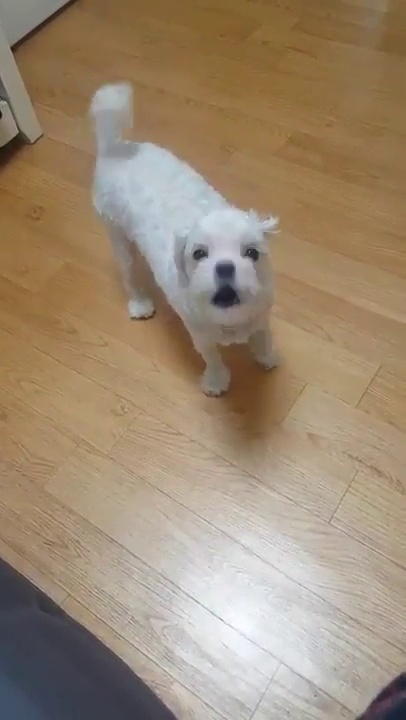

Transcription 완료:  

강아지에 대한 분석을 진행하겠습니다.

### 1. 영상 분석 요약:
- 강아지는 흰색 털을 가진 작은 품종으로 보입니다.
- 강아지는 상체를 약간 앞으로 기울이고, 꼬리를 위로 세운 자세를 취하고 있습니다. 이는 호기심이나 흥분 상태를 나타낼 수 있습니다.
- 강아지의 얼굴은 약간 긴장된 표정으로 보이며, 주목하는 듯한 눈빛을 가지고 있습니다.
- 마지막 프레임에서는 입을 열고 짖는 모습이 관찰됩니다, 이는 주인이나 주변 환경에 대한 반응일 수 있습니다.

### 2. 오디오 분석 요약:
- 오디오에서 강아지의 짖는 소리가 들리며, 이는 경계심이나 관심을 나타낼 수 있습니다.
- 짖음의 톤은 비교적 높고 지속적이며, 불안하거나 흥미로운 상황에 대한 반응으로 해석될 수 있습니다.
- 배경 소음은 확인할 수 없지만, 강아지의 짖음 외에 다른 소음이 있는지 여부도 중요할 수 있습니다.

### 3. 종합 분석:
강아지는 흥미로운 상황에 반응하고 있는 것으로 보이며, 꼬리를 세우고 주목하는 자세는 긍정적인 감정 상태를 나타냅니다. 짖음은 주위 환경에 대한 경계 또는 흥미의 표현일 수 있습니다. 만약 강아지가 자주 이런 행동을 보인다면, 적절한 사회화나 훈련이 필요할 수 있습니다. 전반적으로 건강하고 활발한 상태로 판단됩니다.


1. **영상 분석 요약**: 
   - 강아지는 흰색 털을 가진 중소형 품종으로 보이며, 상반신을 약간 앞으로 기울이며 서 있습니다. 
   - 강아지의 귀는 약간 위로 세워져 있으며, 눈은 크고 주의를 기울이고 있는 모습입니다. 
   - 마지막 프레임에서 강아지는 입을 벌리고 소리를 내고 있는 것처럼 보입니다. 이는 관심이나 흥분을 나타낼 수 있습니다.

2. **오디오 분석 요약**: 
   - 제공된 영상에서 소리 정보를 직접 분석할 수는 없지만, 강아지가 짖는 모습이 관찰되므로 짖음이 있을 것으로 예상됩니다. 
   - 짖음은 강아지가 주목을 받고 싶거나 흥미로운 상황에 반응하는 방식으로 해석

In [40]:
# LLM 분석 템플릿
llm_analysis_template = """
    ** 역할 **
    당신은 20년간 강아지에 대해 공부한 수의사 및 행동 분석가입니다.
    강아지에 대한 풍부한 경험과 전문적인 지식을 보유하고 있습니다.
    제공받은 영상과 오디오를 확인하여 강아지에 대한 분석을 진행합니다.

    ** 분석 프로세스 **
    1. 영상 분석: 
       - 제공된 프레임 단위 이미지를 순서대로 분석합니다.
       - 강아지의 자세, 움직임, 표정을 관찰합니다.
       - 주변 환경과 상황적 맥락을 파악합니다.
       - 보호자가 있다면 그들의 행동도 분석합니다.

    2. 오디오 분석: 
       - 오디오 파형과 주파수 분석으로 강아지의 소리(짖음, 울음 등)의 특성을 파악합니다.
       - 배경 소음이나 다른 소리들도 고려합니다.

    3. 종합 분석:
       - 영상과 오디오 정보를 종합하여 강아지의 전반적인 상태를 평가합니다.
       - 행동 패턴, 감정 상태, 건강 상태에 대한 의견을 제시합니다.
       - 특이사항이나 문제점이 있다면 언급합니다.

    ** 분석 결과 형식 **
    분석 결과를 다음 형식으로 제공해 주세요:
    1. 영상 분석 요약: [영상에서 관찰된 주요 사항들을 간결하게 서술]
    2. 오디오 분석 요약: [오디오에서 파악된 주요 정보를 간결하게 서술]
    3. 종합 분석: [영상과 오디오 정보를 종합한 전반적인 분석 결과]

    주어진 정보를 바탕으로 강아지의 상태를 전문가적 관점에서 분석해 주세요.
"""

def analyze_video(file_path, seconds_per_frame=2):
    base64Frames = []
    base_video_file, _ = os.path.splitext(file_path)
    video = cv2.VideoCapture(file_path)
    if not video.isOpened():
        raise Exception("Error opening video file")
    
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = video.get(cv2.CAP_PROP_FPS)
    frames_to_skip = int(fps * seconds_per_frame)
    
    curr_frame = 0
    while curr_frame < total_frames - 1:
        video.set(cv2.CAP_PROP_POS_FRAMES, curr_frame)
        success, frame = video.read()
        if not success:
            break
        
        _, buffer = cv2.imencode(".jpg", frame)
        base64Frames.append(base64.b64encode(buffer).decode("utf-8"))
        curr_frame += frames_to_skip
    
    video.release()

    clip = VideoFileClip(file_path)
    audio_path = f"{base_video_file}.mp3"
    try:
        if clip.audio:
            clip.audio.write_audiofile(audio_path, bitrate="32k")
            clip.audio.close()
        else:
            audio_path = None
    except Exception as e:
        audio_path = None
    clip.close()
    
    return base64Frames, audio_path

def summarize_video(base64Frames, audio_path):
    summary_text = ""
    
    # 비디오 프레임을 표시합니다.
    display_handle = display(None, display_id=True)
    for img in base64Frames:
        display_handle.update(Image(data=base64.b64decode(img.encode("utf-8")), width=600))
        time.sleep(0.025)

    # 오디오 경로가 None이 아닌 경우에만 transcription을 실행합니다.
    if audio_path is not None:
        with open(audio_path, 'rb') as audio_file:
            transcription = client.audio.transcriptions.create(
                model="whisper-1",
                file=audio_file
            )
            audio_text = transcription.text  # 수정된 부분

            print("Transcription 완료:", audio_text, '\n')
            summary_text += audio_text + "\n"

            response_both = client.chat.completions.create(
                model="gpt-4o-mini-2024-07-18",
                messages=[
                    {"role": "system", "content": "당신은 20년 이상의 경력을 가진 숙련된 블랙박스 영상 분석가입니다. 당신의 역할은 교통사고 현장에서 촬영된 블랙박스 영상을 분석하여 사고의 원인, 과실 비율, 그리고 법률적 판단에 도움을 되는 정보를 제공하는 것 입니다."},
                    {"role": "system", "content": llm_analysis_template},
                    {"role": "user", "content": [
                        "이건 비디오 영상의 프레임 이미지.",
                        *map(lambda x: {"type": "image_url",
                                         "image_url": {"url": f"data:image/jpg;base64,{x}", "detail":"low"}}, base64Frames),
                        {"type": "text", "text": f"이건 비디오 영상의 오디오 {audio_text}"}
                    ]},
                ],
                temperature=0.6
            )
            print(response_both.choices[0].message.content)
            summary_text += response_both.choices[0].message.content + "\n"
            print("\n", "="*100, "\n")

    else:
        print("오디오 내용이 없습니다. Transcription은 스킵합니다", '\n')

    # 오디오가 없는 경우에도 비디오 프레임에 대한 분석을 수행합니다.
    response_vis = client.chat.completions.create(
        model="gpt-4o-mini-2024-07-18",
        messages=[
            {"role": "system", "content": "당신은 20년 이상의 경력을 가진 숙련된 블랙박스 영상 분석가입니다. 당신의 역할은 교통사고 현장에서 촬영된 블랙박스 영상을 분석하여 사고의 원인, 과실 비율, 그리고 법률적 판단에 도움을 되는 정보를 제공하는 것 입니다."},
            {"role": "system", "content": llm_analysis_template},
            {"role": "user", "content": [
                "이건 비디오 영상의 프레임 이미지.",
                *map(lambda x: {"type": "image_url",
                                 "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "low"}}, base64Frames)
            ]},
        ],
        temperature=0.6
    )
    print(response_vis.choices[0].message.content)
    summary_text += response_vis.choices[0].message.content + "\n"
    print("\n", "="*100, "\n")

    return summary_text

# 비디오 파일 경로를 지정하여 실행
video_file_path = "E:/1006/test/2.mp4"  # 여기에 원하는 비디오 파일 경로를 입력하세요
process_video(video_file_path)

#### STEP.5 Vector Search Query 생성, Rag Context 생성

In [ ]:
def get_ret():
    model_name = "BAAI/bge-m3"
    model_kwargs = {"device": "cpu"}
    encode_kwargs = {"normalize_embeddings": True}
    embeddings_model = HuggingFaceEmbeddings(
        model_name=model_name, 
        model_kwargs=model_kwargs, 
        encode_kwargs=encode_kwargs
    )
    
    # general json 자료
    index_name_json = 'dog_test'
    dbName_json = "dbsparta"
    collectionName_json = "dog"
    collection_json = db_client[dbName_json][collectionName_json]

    vectorStore_json = MongoDBAtlasVectorSearch(
        embedding=embeddings_model,
        collection=collection_json,
        index_name=index_name_json,
        embedding_key="embedding",  
        text_key="content" 
    )

    # vectorstore에서 retriever를 생성
    retriever_json = vectorStore_json.as_retriever()
    
    # MergerRetriever를 사용하여 모든 검색기 통합
    merger_retriever = MergerRetriever(retrievers=[retriever_json])
    
    return merger_retriever

query_template = ChatPromptTemplate.from_messages([
    ('system', """
    당신은 강아지 행동 분석 전문가입니다. 주어진 정보를 바탕으로 강아지의 상태를 종합적으로 요약해야 합니다.

    ** 입력 정보 **
    1. YOLO 모델 결과: {yolo_text}
       (강아지 품종 정보)
    2. LSTM 모델 결과: {lstm_text}
       (강아지 행동, 감정, 통증여부, 질병여부, 비정상 행동 정보)
    3. LLM 비디오/오디오 분석 요약: {summary_text}
       (강아지의 시각적 행동 패턴, 소리, 환경 정보 등)

    ** 요약 지침 **
    1. 모든 입력 정보를 통합하여 강아지의 상태를 종합적으로 설명하세요.
    2. 품종, 주요 행동, 감정 상태, 건강 상태, 환경적 요인을 포함하세요.
    3. 특이사항이나 문제점이 있다면 간단히 언급하세요.
    4. 전체 요약은 2-3문장으로 제한하세요.
    5. 요약은 키워드 중심으로 작성하고, 불필요한 관사나 조사는 생략하세요.

    위의 지침을 참고하여, 주어진 모든 정보를 바탕으로 강아지의 상태를 종합적으로 요약해주세요.
    """)
])

def generate_query(yolo_text, lstm_text, summary_text):
    response = client.chat.completions.create(
        model="gpt-4o-mini-2024-07-18",
        messages=[
            {"role": "system", "content": query_template.format(
                yolo_text=yolo_text,
                lstm_text=lstm_text,
                summary_text=summary_text
            )},
            {"role": "user", "content": "비디오를 종합적으로 요약해주세요."}
        ],
        max_tokens=100
    )
    
    query = response.choices[0].message.content
    return query

query = generate_query(yolo_text, lstm_text, summary_text)

#### STEP.6 LLM 모델 최종 답변 생성

In [ ]:
comprehensive_analysis_template = ChatPromptTemplate.from_messages([
    ("system", """
    당신은 20년 경력의 수의사이자 강아지 행동 분석 전문가입니다. 주어진 모든 정보를 종합하여 강아지의 상태를 분석하고 전문적인 조언을 제공해야 합니다.

    ** 입력 정보 **
    1. YOLO 분석 결과: {yolo_text}
    2. LSTM 분석 결과: {lstm_text}
    3. LLM 비디오 분석 결과: {llm_text}
    4. RAG 문서 정보: {context}

    ** 유저와의 상호작용 **
    모든 대화는 한국어로 진행됩니다.

    ** 분석 및 답변 지침 **
    1. 모든 입력 정보를 종합하여 강아지의 상태, 행동, 감정, 건강 상태를 정확히 파악하세요.
    2. YOLO 결과로부터 강아지의 품종과 외형적 특징을 고려하세요.
    3. LSTM 결과를 바탕으로 강아지의 행동 패턴과 감정 상태, 통증여부, 이상행동 여부를 분석하세요.
    4. LLM 비디오 분석 결과를 통해 전반적인 상황 맥락을 이해하세요.
    5. RAG 문서 정보를 활용하여 관련된 전문 지식을 답변에 통합하세요.
    6. 문제가 있다면 그 원인을 간단히 설명하고, 구체적이고 실행 가능한 해결책을 제시하세요.
    7. 보호자가 즉시 실천할 수 있는 실용적인 조언을 포함하세요.
    8. 필요한 경우 전문가 상담이나 병원 방문을 권유하세요.
    9. 답변은 전문적이면서도 이해하기 쉽게 작성하세요.
    
    ** 답변 구조 **
    1. 종합적 상황 요약 (YOLO, LSTM, LLM 결과 통합)
    2. 원인 분석 (해당되는 경우)
    3. 맞춤형 해결책 또는 권장 행동 (RAG 정보 활용)
    4. 추가 조언 또는 주의사항 (필요한 경우)
    5. 결론 및 격려의 말

    주어진 모든 정보를 종합하여 전문적이고 실용적인 분석과 조언을 제공해주세요.
    """),
    MessagesPlaceholder(variable_name="chat_history"),
    ("human", "{question}")
])

def generate_comprehensive_analysis(yolo_text, lstm_text, llm_text, context):
    response = client.chat.completions.create(
        model="gpt-4o-mini-2024-07-18", 
        messages=[
            {"role": "system", "content": comprehensive_analysis_template.format(
                yolo_text=yolo_text,
                lstm_text=lstm_text,
                llm_text=llm_text,
                context=context
            )},
            {"role": "user", "content": "강아지의 상태를 분석하고 조언해주세요."}
        ],
        max_tokens=1000
    )
    return response.choices[0].message.content


analysis_result = generate_comprehensive_analysis(yolo_text, lstm_text, llm_text, context)
print(analysis_result)

# AI 파이프라인 정리

1. **YOLO_v8 모델 분석**: 비디오(강아지 품종, keypoint, bounding box)

2. **LSTM 모델 분석**: 키포인트(강아지 행동패턴, 감정, 통증여부, 비정상 행동 정보)
---------------------------------------------------------------------------
3. **LLM 모델 분석**: 비디오(영상, 오디오 분석 - 요약)

4. **Retriever 생성**: 모델 분석 결과(yolo, lstm, llm 텍스트) - LLM 요약

5. **Vector Search, RAG Context 생성**

6. **LLM 모델 최종 답변 생성**: 
   - 품종
   - 행동패턴
   - 감정
   - 통증여부
   - 비정상 행동 정보
   - LLM 요약
   - RAG 문서 정보
   -------------------------------------------------------------------------

#### 병렬처리

In [ ]:
# 비디오 프레임 추출을 병렬화
def extract_frames_parallel(video_path, seconds_per_frame=2):
    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = video.get(cv2.CAP_PROP_FPS)
    frames_to_skip = int(fps * seconds_per_frame)

    def process_frame(frame_num):
        video.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        success, frame = video.read()
        if success:
            _, buffer = cv2.imencode(".jpg", frame)
            return base64.b64encode(buffer).decode("utf-8")
        return None

    with concurrent.futures.ThreadPoolExecutor() as executor:
        frames = list(executor.map(process_frame, range(0, total_frames, frames_to_skip)))

    video.release()
    return [frame for frame in frames if frame is not None]

# YOLO 모델 실행을 병렬화
def run_yolo_parallel(yolo_model, source, conf_thresh):
    results = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = {executor.submit(yolo_model.predict, source=frame, conf=conf_thresh): frame for frame in source}
        for future in concurrent.futures.as_completed(futures):
            results.append(future.result())
    return results

# LSTM 모델 실행을 병렬화 (GPU 사용 가능 시)
def run_lstm_parallel(model, keypoints_tensor, skeleton_tensor):
    with torch.cuda.device(0):
        return model(keypoints_tensor.cuda(), skeleton_tensor.cuda())

# OpenAI API 호출을 비동기로 처리
async def call_openai_api_async(client, model, messages, max_tokens):
    async with aiohttp.ClientSession() as session:
        async with session.post(
            "https://api.openai.com/v1/chat/completions",
            headers={"Authorization": f"Bearer {os.getenv('OPENAI_API_KEY')}"},
            json={
                "model": model,
                "messages": messages,
                "max_tokens": max_tokens
            }
        ) as response:
            return await response.json()

# 메인 실행 함수
async def main(video_path, yolo_model, model, keypoints_tensor, skeleton_tensor, client, conf_thresh):
    # 비디오 프레임 추출
    base64Frames = extract_frames_parallel(video_path)

    # YOLO 모델 실행
    yolo_results = run_yolo_parallel(yolo_model, base64Frames, conf_thresh)

    # LSTM 모델 실행 (GPU 사용 가능 시)
    lstm_output = run_lstm_parallel(model, keypoints_tensor, skeleton_tensor)

    # OpenAI API 호출
    tasks = [
        call_openai_api_async(client, "gpt-4o-mini-2024-07-18", [...], 1000),
        call_openai_api_async(client, "gpt-4o-mini-2024-07-18", [...], 100),
        call_openai_api_async(client, "gpt-4o-mini-2024-07-18", [...], 1000)
    ]
    api_results = await asyncio.gather(*tasks)

    # 결과 처리
    # ...

# 비동기 실행
if __name__ == "__main__":
    video_path = "your_video_path.mp4"  # 비디오 파일 경로
    yolo_model = "your_yolo_model"  # YOLO 모델
    model = "your_lstm_model"  # LSTM 모델
    keypoints_tensor = "your_keypoints_tensor"  # 키포인트 텐서
    skeleton_tensor = "your_skeleton_tensor"  # 스켈레톤 텐서
    client = "your_openai_client"  # OpenAI 클라이언트
    conf_thresh = 0.5  # 신뢰도 임계값

    asyncio.run(main(video_path, yolo_model, model, keypoints_tensor, skeleton_tensor, client, conf_thresh))
